In [25]:
import numpy as np
import os, re, time, pickle, codecs, random
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.stem.snowball import SpanishStemmer
from sklearn.decomposition import PCA
import pylab

pylab.rcParams['figure.figsize'] = (14, 14) # Tamaño de los plots

# PRÁCTICA 3: Procesamiento de Lenguaje Natural
# EMBEDDINGS

Fecha: 30 de noviembre de 2018

Alumnos:
- 
- Diego-Fernández Chaparro-Plata Javier
- Vargas Castro Daniel
- Velázquez Sánchez José Antonio

# Introducción

El modelo de Skip-gram fue propuesto por Mikolov, Chen, Corrado y Dean para obtener representaciones vectoriales semánticamente significativas de un conjunto dado de palabras [1]. Consiste en un modelo neuronal que toma una palabra como entrada y dispone como salida el contexto de dicha palabra, teniendo una capa oculta cuyo propósito es codificar la palabra de entrada en un embedding. Tras entrenar sobre un conjunto basto de pares palabra-contexto, sacados previamente de algún corpus, los embeddings obtenidos suelen tener propiedades significativas para representar a las palabras en diversas tareas de Machine Learning como por ejemplo el clustering de palabras.

En esta práctica se nos presentó con dos problemas distintos y con la tarea de basarnos en el modelo de Skip-gram para resolverlos. En el primer problema se nos da un conjunto de 100 documentos y el objetivo es obtener un embedding de cada uno, utilizando un modelo donde la entrada sea el índice de un documento y la salida sean los índices de las palabras presentes en dicho documento. En el segundo problema se nos da un conjunto de palabras en una lengua A, y sus traducciones en una lengua B, y el objetivo es obtener embeddings para las palabras de la lengua A utilizando un modelo que tome como entrada un índice de una palabra de la lengua A y como salida los índices de las palabras de la lengua B que sean sus traducciones.

Fue necesario realizar un proceso experimental para llegar a los parámetros que dieran buenos resultados. Para esto nos basamos en los papers de Mikolov et. al sobre Skipgram [1] [2] y encontramos que en sus experimentos utilizaron un learning rate de 0.025 que decrementaba linealmente en cada iteración hasta llegar a 0.001, haciendo solo un total de 5 iteraciones sobre todo el corpus. Debido a esto, preferimos un número pequeño de iteraciones, así como un learning rate muy pequeño, considerando, sin embargo, que los corpus con los que trabajamos son mucho menores que los corpus utilizados por Mikolov y su equipo.

Para medir el desempeño del modelo a través del entrenamiento utilizamos 3 métodos:
- **Función de pérdida**: Mikolov et. al definen como función objetivo del modelo de Skip gram el maximizar la suma del logaritmo de la probabilidad de que las palabras del contexto de $w_j$ estén en el contexto de dicha palabra [2]. Llamamos "función de pérdida" al negativo de esta función, ya que el objetivo sería minimizar la función de pérdida:

\begin{equation*}
\textrm{Pérdida} = - \frac{1}{\mid T \mid} \sum_{w_t \in T} \sum_{w_j \in C(w_t)} log(p(w_j \mid w_t))
\end{equation*}

Donde $T$ es el conjunto de palabras de entrada para las que tengamos un contexto de salida definido, y $C(w_t)$ es el conjunto de palabras en el contexto de salida de $w_t$. Puesto que ésta es la función definida por los creadores del modelo Skip-gram, ésta es la función que se busca minimizar en el proceso de backpropagation.

- **Entropía Cruzada Promedio**: recordando el concepto visto en clase de Entropía Cruzada, se nos ocurrió utilizarla para medir el desempeño del modelo. La idea es que la salida de la red es una distribución de probabilidad (softmax) y por tanto se podría comparar contra una distribución de probabilidad ideal que se calcularía a partir del contexto de salida de $w_j$. Esta distribución ideal de salida no es más que dar a cada elemento del contexto de $w_j$ la misma probabilidad de aparecer dado $w_j$, y a todos los demás elementos que no estén en el contexto de $w_j$ darles probabilidad 0. Luego, para cada entrada calculamos la entropía, y obtenemos un promedio de todas ellas.

\begin{equation*}
\textrm{Entropía Cruzada Promedio} = - \frac{1}{\mid T \mid} \sum_{w_t \in T} \sum_{w_j \in S} p_{r}(w_j \mid w_t) * log(p_{m}(w_j \mid w_t))
\end{equation*}

Donde $T$ se define igual que en la función de pérdida, $S$ es el vocabulario de salida, $p_{m}$ es la distribución de probabilidad estimada por el modelo y $p_r$ es la distribución de probabilidad "real" que debería estimar el modelo tomando las consdieraciones ya explicadas.

- **Error Promedio en la Distribución de Salida**: Igual que en la anterior, se nos ocurrió esta métrica al considerar la salida del modelo como una distribución de probabilidad. Particularmente notamos que si sumamos las probabilidades de las palabras de un contexto dado para una palabra de entrada, esta suma debería de dar idealmente 1. Así definimos un "error" como la diferencia que hay con respecto al 1, y promediamos esta diferencia a través de todo el vocabulario de entrada. Entendemos que no es una medida del todo robusta, ya que no indicaría cuando un elemento del contexto esté acaparando mayor probabilidad que los otros; aún así decidimos implementarla para complementar los resultados experimentales y nuestra comprensión del modelo.

\begin{equation*}
\textrm{Error Promedio} = \frac{1}{\mid T \mid} \sum_{w_t \in T} 1 - \sum_{w_j \in C(w_t)} p(w_j \mid w_t)
\end{equation*}

Para poder utiizar el modelo inspirado en word2vec y las anteriores fórmulas de desempeño, creamos una clase llamada One2Vec, la cual funciona como word2vec pero con la diferencia de que la entrada y la salida no tienen que ser el mismo vocabulario. En su lugar, la clase One2Vec solamente recibe un índice como entrada y un conjunto de índices como salida, considerando que el vocabulario de salida puede ser diferente al vocabulario de entrada.

Cabe aclarar que aunque hablamos de "vocabularios" de entrada y de salida, nos referimos a cualquier conjunto cuyos elementos han sido asociados con una función biyectiva a un índice entero; sin embargo, usamos el término "vocabulario" para referirnos al conjunto por la semejanza que tiene al vocabulario de word2vec. En el caso del ejercicio 1 de la práctica, el vocabulario de entrada sería el conjunto de los documentos, y el vocabulario de salida sería el conjunto de palabras existentes en todos los documentos. En el ejercicio 2 el vocabulario de entrada consiste en el conjunto de palabras del lenguaje de origen, y el vocabulario de salida sería el conjunto de palabras del lenguaje objetivo. La clase One2Vec solamente lidia con los índices de los elementos de ambos vocabularios y obtiene los embeddings de todos los elementos del vocabulario de entrada. Para esto, la clase One2Vec no guarda información de cómo interpretar los índices, sino solamente de cómo entrenar el modelo, y solo es necesario inicializar la clase indicando el tamaño del vocabulario de entrada y del vocabulario de salida.

# Modelo neuronal

In [41]:
class One2Vec():
    """
    Clase para utilizar el modelo neuronal inspirado en el modelo de skipgram
    para obtener embeddings de palabras (word2vec)
    
    Como en skipgram se entiende que la entrada de este modelo neuronal es un
    vector one-hot-encoding, que tiene solamente ceros excepto en una posición
    específica.
    
    Sin embargo, en este modelo que usamos, el tamaño del vector de salida
    no necesariamente tiene que ser del mismo tamaño que el de entrada, ya que
    aquí no estamos relacionando palabras del mismo vocabulario para obtener
    embeddings.
    """
    
    def __init__(self, dim_in, dim_out, dim_embedding = 100):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_embedding = dim_embedding
        
        self.W = np.random.random((dim_in, dim_embedding))
        self.U = np.random.random((dim_embedding, dim_out))
        
    def hotencoding(self, index, size):
        """
        Devuelve un vector de ceros de tamaño "size"
        con un solo 1 en la posición indicada por index.
        
        :param index: entero
        :param size: entero
        :returns arreglo
        """
        v = np.zeros(size)
        v[index] = 1
        return v
    
    def fit(self, X, Y, epochs = 1000, initial_learning_rate = .1, ending_learning_rate = 0.001):
        """
        Realiza el entrenamiento del modelo.
        
        :param X: lista de enteros. Cada entero representa el indice del dato de
            entrada al que se asocia la salida.
            
        :param Y: lista de listas de enteros. Del mismo tamaño que X. Y[i] es el
            conjunto de indices de salida asociados a X[i]
            
        :param epochs: entero. Número de iteraciones que se harán sobre todo el
            dataset.
            
        :param initial_learning_rate: flotante
        
        :param ending_learning_rate: flotante. El learning rate decrece en cada
        iteración de manera lineal hasta llegar a este valor.
        
        :returns Nada
        """
        inicio = time.time()
        
        learning_rate_delta = (initial_learning_rate - ending_learning_rate)/(epochs - 1)
        learning_rate = initial_learning_rate
        for epoch in range(epochs):
            loss = 0
            for j, x in enumerate(X):
                # Feedforward:
                salida1 = self.W[x]
                salida2 = np.dot(self.U.T, salida1)
                salida_softmax = np.exp(salida2 - np.max(salida2))/np.sum(np.exp(salida2 - np.max(salida2))) # se debe restar el máximo para evitar overflows
                
                # Backpropagation:
                vector_error = np.sum([salida_softmax - self.hotencoding(c, self.dim_out) for c in Y[j]], axis = 0)
                self.W[x] -= learning_rate * np.dot(self.U, vector_error)
                self.U -= learning_rate * np.outer(salida1, vector_error)
            
            learning_rate -= learning_rate_delta
            
            if epoch % (epochs // 4) == 0 or epoch == epochs -1:
                print("Época: {0} - Tiempo: {1:.2f} mins.".format(epoch + 1, (time.time() - inicio) /60 ))
                self.evaluate(X, Y)
                print()
    
    def get_embeddings(self):
        """
        Devuelve los embeddings aprendidos por la red.
        El renglón "i" representa el embedding del elemento
        de entrada "i"
        
        :returns matriz de embeddings
        """
        return self.W
    
    def _cross_entropy(self, p, q):
        """
        Función auxiliar. Dados dos vectores p y q representando distribuciones
        de probabilidad, devuelve la entropía cruzada de ambos.
        
        Si q tiene algún elemento igual a 0, esta función devuelve un error.
        
        :param p: arreglo. Distribución de probabilidad que se toma como "ground truth"
        :param q: arreglo. Distribución de probabilidad estimada.
        :returns flotante: entropía cruzada de p y q
        """
        return - np.dot(p, np.log(q))
    
    def _predict(self, x):
        """
        Devuelve la salida que se activa en la red dado un indice de entrada.
        Básicamente es la distribución de probabilidad (Softmax) en la salida
        dada una entrada específica.
        
        :param x: entero.
        
        :returns vector de salida. Es una distribución de probabilidad, debido
            a que se aplica softmax.
        """
        salida = np.dot(self.U.T, self.W[x])
        return np.exp(salida - np.max(salida))/np.sum(np.exp(salida - np.max(salida)))
    
    def evaluate(self, X, Y):
        """
        Dado un conjunto de datos (X, Y), se calcula la entropía cruzada
        de evaluar cada entrada en el modelo y compararla con la que
        debería ser la distribución de salida. Y también calcular
        un error en la distribución promedio.
        
        :param X: lista de indices de entrada
        :param Y: lista de listas de indices de contexto de salida
        :returns Nada
        """
        suma_entropia = 0
        suma_punto = 0
        loss = 0
        for i in range(len(X)):
            y = self.hotencoding(Y[i], self.dim_out)
            y_estimada = self._predict(X[i])

            loss += - np.dot(np.log(y_estimada), y)
            suma_entropia += self._cross_entropy(y /np.sum(y), y_estimada)
            suma_punto += 1 - np.dot(y, y_estimada)

        print("\tFunción de Pérdida:", loss / len(X))
        print("\tEntropia Cruzada promedio:", suma_entropia / len(X))
        print("\tError en la distrib promedio (producto punto):", suma_punto / len(X))
        
    def save(self, path):
        """
        Serializa las matrices U y W en un archivo pickle para guardar
        en disco los resultados del entrenamiento
        """
        d = {'W': self.W, 'U': self.U}
        pickle.dump(d, open(path, "wb"))
        
    def load (self, path):
        """
        Carga las matrices U y W serializadas usando el método save,
        y ajusta los atributos necesarios de la clase One2Vec para que
        sea funcional con dichas matrices.
        
        Debido a esto, los datos cargados sobreescriben los datos originales
        en esta clase.
        """
        d = pickle.load(open(path, "rb"))
        self.W = d['W']
        self.U = d['U']
        
        self.dim_in, self.dim_embedding = self.W.shape
        _, self.dim_out = self.U.shape

# Funciones Auxiliares

Estas funciones sirven para definir un vocabulario, y la relación entre palabras de vocabularios y el conjunto de índices que serán utilizados por One2Vec.

In [13]:
def word2index():
    """
    Devuelve un defaultdict que sirve para asociar una palabra (string)
    a un indice.
    """
    dicc = defaultdict()
    dicc.default_factory = lambda: len(dicc)
    return dicc

def create_index2word(word2index):
    """
    Dado un diccionario word2index, devuelve otro diccionario
    que asocia un indice a una palabra.
    """
    index2word = dict()
    for k, v in word2index.items():
        index2word[v] = k
    return index2word

# Ejercicio 1: De documento a palabras

En este ejercicio se nos dan 100 documentos de texto, y se nos pide encontrar embeddings para cada uno. Para ello se entrenará el modelo considerando como entrada el índice del documento, y como salida el conjunto de índices de las palabras que aparecen en el documento.

Primero, leemos la información directamente desde los archivos del corpus para así obtener el vocabulario de salida, asociar un índice a cada palabra de dicho vocabulario, una lista de listas con los indices de las palabras presentes en cada documento, y una lista con los nombres de los documentos

In [18]:
corpus1dir = "./datasets/CorpusDocs"

word2index1 = word2index() # contendrá al vocabulario de salida, asociando una palabra a su indice
stemizador = SpanishStemmer() # Para hacer stemming
docs = [] # lista de listas, donde docs[i] tiene la lista de indices de las palabras del documento #i
docs_titles = [] # lista de titulos

r = re.compile("[^\W\d]+") # Filtramos digitos y cualquier tipo de puntuación

for textfile in os.listdir(corpus1dir):
    with codecs.open(os.path.join(corpus1dir, textfile), "r", 'utf-8') as inputf:
        doc = []
        for line in inputf:
            tokens = r.findall(line)
            for token in tokens:
                doc.append(word2index1[stemizador.stem(token)])

        docs_titles.append(textfile)
        docs.append(list(set(doc)))

index2word1 = create_index2word(word2index1) # asociará un índice a una palabra del vocabulario de salida

In [35]:
print("Número de documentos leídos:", len(docs))
print("Tamaño del vocabulario de salida:", len(word2index1))
print()

doc_n = 10 # Documento a  mostrar como ejemplo
print("Documento Ejemplo:", docs_titles[doc_n])
print(" ".join([index2word1[t] for t in docs[doc_n]]))

Número de documentos leídos: 100
Tamaño del vocabulario de salida: 8202

Documento Ejemplo: buchnera (1).txt
orden una es vertical que desarroll se asoci con genom lo en un y tal gener continu conoc de multipl mayor las estrict del cad la a factor su genet com mod tambien par sol mas los no pued result permit sin cre ha aminoac larg vid entre sus domini tod esto viv tien al comienz uno algun perd denomin ocasion buchner aphidicol commons emblem notic svg clasif bacteri fil proteobacteri clas gammaproteobacteri enterobacterial enterobacteriacea b famli endosimbiont primari afid gram negat simil escherichi coli diametr µm parient embarg contrari organ carec codific lipopolisacar lps exterior limit cruz cromosom requer respir anaerob sintesis famili amin azucar acid gras fosfolip carbohidrat pequeñ establ simbiot persit maternal co especializcion celul bacteriocit hosped estim madur regul sobrerproduccion triptofan conten vesicul simbiosom deriv citoplasmat traves especi complej millon añ

Para entrenar el modelo hicimos varias pruebas, y llegamos a la conclusión de que lo mejor era usar 100 épocas y un learning rate inicial muy pequeño de 0.005

In [43]:
# ENTRENANDO EL MODELO:
ndocs = len(docs)
nwords = len(word2index1)
X1 = list(range(len(docs)))

model1 = One2Vec(ndocs, nwords, dim_embedding = 100)
model1.fit(X1, docs, epochs = 100, initial_learning_rate = .005)
model1.save("./pickles/model1.pickle")

Época: 1 - Tiempo: 0.05 mins.
	Función de Pérdida: 2615.57919646781
	Entropia Cruzada promedio: 8.562125244852757
	Error en la distrib promedio (producto punto): 0.8220786928631542

Época: 26 - Tiempo: 1.26 mins.
	Función de Pérdida: 2257.158541034077
	Entropia Cruzada promedio: 7.057553847439521
	Error en la distrib promedio (producto punto): 0.6126905560087553

Época: 51 - Tiempo: 2.42 mins.
	Función de Pérdida: 2040.906748385043
	Entropia Cruzada promedio: 6.212026192983789
	Error en la distrib promedio (producto punto): 0.37535702947978933

Época: 76 - Tiempo: 3.58 mins.
	Función de Pérdida: 1914.227294003203
	Entropia Cruzada promedio: 5.771496301834817
	Error en la distrib promedio (producto punto): 0.2189318007594849

Época: 100 - Tiempo: 4.79 mins.
	Función de Pérdida: 1872.850204573646
	Entropia Cruzada promedio: 5.632562170265272
	Error en la distrib promedio (producto punto): 0.15478167477994098



# Ejercicio 2: Palabras de una lengua a otra

En este ejercicio se nos dió un archivo de texto que contenía un conjunto de palabras de una lengua (que llamamos "Lengua A"), y un conjunto de traducciones a otra lengua (que llamamos "Lengua B"). El propósito es obtener embeddings de las palabras la lengua A, entrenando el modelo con las traducciones en la Lengua B como salida de la red.

Primero leemos el archivo original y de ahí obtenemos un diccionario de traducciones, así como los diccionarios correspondientes de los vocabularios de cada lengua que asocien una palabra a un índice y viceversa.

In [47]:
inputfile2 = "./datasets/graph.txt"

traducciones = defaultdict(list) # diccionario que asocia las palabras de la lengua A con las palabras de la lengua B
word2index2A = word2index() # diccionario que asocia cada palabra de la lengua A con su índice
word2index2B = word2index() # diccionario que asocia cada palabra de la lengua B con su índice

with codecs.open(inputfile2, "r", 'utf-8') as inputf:
    palabras_relacionadas = []
    for line in inputf:
        if line[0] == '\t':
            traducciones[currindexA].append(word2index2B[line.strip()])
        else:
            currindexA = word2index2A[line.strip()]
            traducciones[currindexA] = []
            
index2word2A = create_index2word(word2index2A) # diccionario que asocia un índice con su palabra correspondiente de la lengua A
index2word2B = create_index2word(word2index2B) # diccionario que asocia un índice con su palabra correspondiente de la lengua B

In [48]:
print("Número de Palabras en la Lengua A:", len(index2word2A))
print("Número de Palabras en la Lengua B:", len(index2word2B))
print()

print("Algunas palabras de la lengua A:")
print(", ".join([index2word2A[index] for index in list(traducciones.keys())[:100]]), " ... ")
print()

print("Algunas traducciones:")
for palabraA in list(traducciones.keys())[:10]:
    palabrasB = [index2word2B[indexb] for indexb in traducciones[palabraA]]
    print(index2word2A[palabraA], ":", ", ".join(palabrasB))

Número de Palabras en la Lengua A: 929
Número de Palabras en la Lengua B: 1339

Algunas palabras de la lengua A:
a, abasto, ablandar, abono, abrazar, abuela, abuelita, abuelo, acabado, acabar, aceite, acercar, acocil, acomodar, acostar, activar, adentro, afortunadamente, afuera, agarrar, agregar, agrio, agua, agua.caliente, agua.fría, aguantar, aguardiente, agujerear/a, ah, ahora, ahí, ajolote, al, al.instante, ala, albañil, alcanzar, alegrar, alejar, alfalfa, algo, alimentar, alimento, aliviar, allá, allí, almorzar, alrededor, alzar, amamantar, amanecer, amenazar, amiga, amontonar, ancho, andar, animal, animal.de.Dios, antes, aparecer, apenas, aplastar, apostillar, aprender, apurar, aquí, arrebatar, arreglar, arreglo, arriba, arroz, asado, asentar, asiento, asustarse, así, así.es.que, atacar, atascadera, atormentar, atrio, atrás, aunque, aventar, ay, ayer, ayudar, ayunar, ayuntamiento, año, años, bailar, baile, bajar, barreno, barrer, barril, bastante, batir, bautizar  ... 

Algunas t

Para el este modelo, tras hacer pruebas descubrimos que .025 era un buen learning rate, y que se podían hacer más de 1000 iteraciones sin problemas. Sin embargo, también notamos que después de 100 iteraciones las métricas de desempeño cambian poco.

In [49]:
# Creando el dataset:
X2 = []
Y2 = []
for palabraA, palabrasB in traducciones.items():
    X2.append(palabraA)
    Y2.append(palabrasB)

# Entrenando el modelo:
npalabrasA = len(index2word2A)
npalabrasB = len(index2word2B)
model2 = One2Vec(npalabrasA, npalabrasB, dim_embedding = 100)
model2.fit(X2, Y2, epochs = 1000, initial_learning_rate = .025)
model2.save("./pickles/model2.pickle")

Época: 1 - Tiempo: 0.02 mins.
	Función de Pérdida: 10.788966964211138
	Entropia Cruzada promedio: 7.388192842562653
	Error en la distrib promedio (producto punto): 0.9981596745975609

Época: 251 - Tiempo: 6.31 mins.
	Función de Pérdida: 0.823839930337719
	Entropia Cruzada promedio: 0.25876377392757294
	Error en la distrib promedio (producto punto): 0.008263591458131441

Época: 501 - Tiempo: 12.41 mins.
	Función de Pérdida: 0.8187718678407236
	Entropia Cruzada promedio: 0.2549533423722768
	Error en la distrib promedio (producto punto): 0.004478254785699622

Época: 751 - Tiempo: 18.61 mins.
	Función de Pérdida: 0.817421585408298
	Entropia Cruzada promedio: 0.25393747102676983
	Error en la distrib promedio (producto punto): 0.003466549582443449

Época: 1000 - Tiempo: 24.57 mins.
	Función de Pérdida: 0.8170380158694533
	Entropia Cruzada promedio: 0.25364880278259677
	Error en la distrib promedio (producto punto): 0.003178870171110404



# Resultados

*Nota: los resultados mostrados cargan el archivo .pickle guardado tras el entrenamiento de los dos anteriores ejercicios, para que así no sea necesario volver a entrenar los modelos cada vez que se quiera visualizar los resultados.*

In [32]:
def plot_words(datos, etiquetas, titulo, colores = 'red'):
    """
    Plotea el conjunto de datos Z añadiendo las etiquetas dispuestas en ids
    
    :param datos: arreglo bidimensional.
    :param etiquetas: lista de strings. Del mismo tamaño que Z[0]
    :param colores: string o lista de strings con los colores de cada punto
    """
    r=0
    plt.scatter(datos[:,0],datos[:,1], marker='o', c= colores)
    for label, x, y in zip(etiquetas, datos[:,0], datos[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.title(titulo)
    plt.show()

Para el Ejercicio 1 ploteamos un vector por cada documento, acompañado por el nombre del documento. Generamos, además, una lista de colores dependiendo del título del documento para así poder diferenciar mejor los resultados en la gráfica.

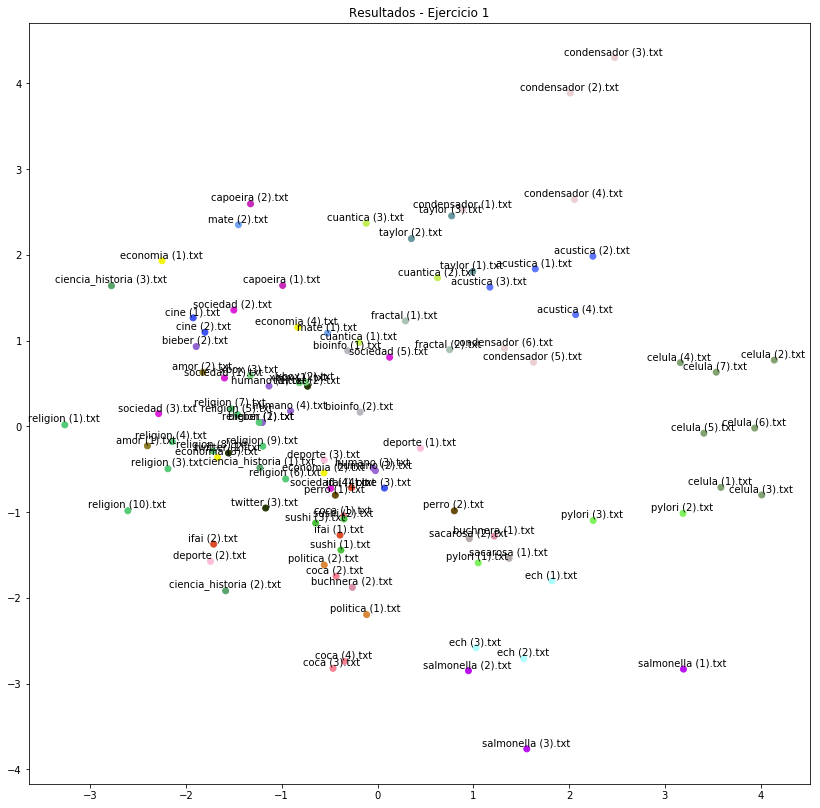

In [44]:
model1 = One2Vec(1,1)
model1.load("./pickles/model1.pickle")

def title2color():
    dicc = defaultdict()
    r = lambda: random.randint(0,255)
    dicc.default_factory = lambda: "#{0:02x}{1:02x}{2:02x}".format(r(), r(), r())
    return dicc

colores = []
t2c = title2color()
for title in docs_titles:
    title = title.split(" ")[0]
    colores.append(t2c[title])

pca = PCA(n_components=2)
embeddings2D = pca.fit_transform(model1.get_embeddings())
plot_words(embeddings2D, docs_titles, "Resultados - Ejercicio 1", colores)

Para el ejercicio dos, ploteamos un punto por cada palabra del lenguaje A, etiquetado con el texto de la palabra.

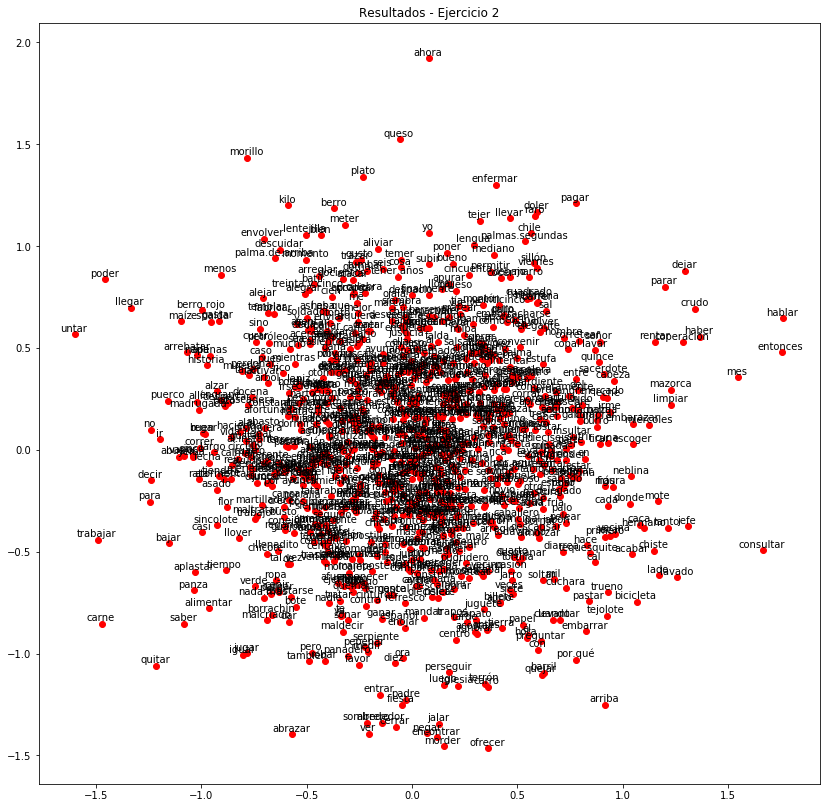

In [50]:
model2 = One2Vec(1,1)
model2.load("./pickles/model2.pickle")

palabras = [index2word2A[x] for x in X2]
pca = PCA(n_components=2)
embeddings2D = pca.fit_transform(model2.get_embeddings())
maxw = None # Para plotear menos palabras, cambiar este parámetro a un número entero que sea el máximo número de palabras deseadas
plot_words(embeddings2D[:maxw], palabras[:maxw], "Resultados - Ejercicio 2")

# Conclusiones y comentarios
## Ejercicio 1:
- El corpus del ejercicio 1 fue el que más problemas nos dió a la hora de entrenar. Como fue comentado con el maestro, se presentaron varios overflows si no ajustábamos bien la taza de aprendizaje, y la mejor opción fue reducir el número de iteraciones a solo 100, y con una taza de aprendizaje relativamente pequeña de .001.
- Pese a lo anterior, se puede ver en los resultados que los embeddings sí alcanzan a codificar diferencias en los documentos. De manera general se alcanzan a ver clusters más o menos definidos para los documentos de "célula", "salmonella", "pylori", "condensador", "acústica" y "cuántica". Y en general se alcanza a ver que existen clusters más amplios que parecen agrupar temas relacionados a biología, otro sobre física, y otro sobre ciencias sociales y humanidades en general.
- Además, gracias a las métricas de desmpeño, podemos ver que hay una gran mejora entre la primera época y la 100, dando pie a creer que quizás algunas iteraciones más habrían mejorado la calidad de los embeddings.

## Ejercicio 2:
- A diferencia del ejercicio 1, el corpus de este ejercicio sí se logró entrenar sin mayor problema, aún considerando 1000 épocas y un learning rate inicial de 0.025.
- Podemos ver en las métricas del desempeño que ya incluso desde la primera iteración los valores de pérdida, entropía cruzada promedio y error promedio en la distribución de salida son mucho menores que en el primer ejercicio.
- Nuestra interpretación de los dos puntos anteriores es que la naturaleza del problema del ejercicio 2 es muy distinta a la del ejercicio 1, y más cercana a lo que se propone en word2vec por lo que el modelo fue más fácil de entrenar y tuvo mejores métricas que en el anterior. La diferencia clave que encontramos entre el ejercicio 1 y el ejercicio 2, es que en el segundo ejercicio cada índice de entrada se asocia a pocos índices de salida (como en word2vec que el contexto en la salida suele ser de a lo mucho 5 palabras), mientras que en el primero cada documento de entrada se asociaba incluso a miles de elementos en la salida. La diferencia se acentúa al considerar que por cada elemento de entrada tenemos definido solo un conjunto de salida en ambos ejercicios, y a diferencia de word2vec donde por cada elemento de entrada se tienen muchos contextos distintos donde se da lugar a la repetición de ciertos elementos de salida, pero no a otros. Debido a estas razones creemos que en el ejercicio 1 se necesitaría una taza de aprendizaje sumamente pequeña (mucho más pequeña que 0.001) para que la actualización del backpropagation no ocasionara un overflow, y en su lugar preferimos usar menos épocas. Así mismo, por estas mismas razones, es que en el ejercicio 2 sí pudimos utilizar muchas iteraciones sin tener que bajar demasiado la taza de aprendizaje.
- Pese a que las métricas son mejores en el ejercicio 2 y se pudieron hacer más épocas, no logramos encontrar ningún patrón claro en los embeddings que resultaron. Creemos que esto es normal, ya que a diferencia del ejercicio 1 donde las palabras de salida aparecerían en documentos similares, en el ejercicio 2 no se define el suficiente número de traducciones para cada palabra de entrada como para poder lograr codificar información relevante sobre cómo se asocian éstas palabras entre sí.

# Referencias
[1] "Efficient Estimation of Word Representations in Vector Space" (2013). Mikolov, Sutskever, Chen, Corrado y Dean. Google Inc.

[2] "Distributed Representations of Words and Phrases and their Compositionality" (2013). Mikolov, Sutskever, Chen, Corrado y Dean. Google Inc.